# [Exploration 17] Movielens 영화 SBR 

Movielens 1M Dataset을 기반으로 Session Based Recommendation(SBR)시스템 제작

---

## 프로젝트 목표
---
- 이미지 해상도에 대한 이해
- Bicubic Interpolation, SRGAN으로 실험 후 비교

## 프로젝트 설명
---
1. 데이터의 전처리
    - 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
    - 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.
2. 미니 배치의 구성
    - 실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
    - 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.
3. 모델 구성
    - 이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.
4. 모델 학습
    - 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.
5. 모델 테스트 
    - 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

## 0. 데이터 불러오기

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import datetime as dt
from dateutil import tz
from pathlib import Path
import os

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [216]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


## 1. 데이터 전처리
- 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

- Movielens 데이터 셋은 session id 대신 user id가 있습니다.
- 한 user id당 몇 개의 데이터를 갖고 있는지 확인하겠습니다.

In [8]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [9]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [10]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [11]:
session_length.min(), session_length.max()

(20, 2314)

- quantile = 소득구간, 변위치 등 구간을 나타내는 개념 
- parameter = 0.999 이면 전체 데이터의 0.999%를 확인할 수 있습니다.

In [15]:
session_length.quantile(0.999)

1343.181000000005

In [16]:
session_length.quantile(0.5)

96.0

- 세션 길이를 시각화해서 이상치가 있는지 확인해보겠습니다.

In [28]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

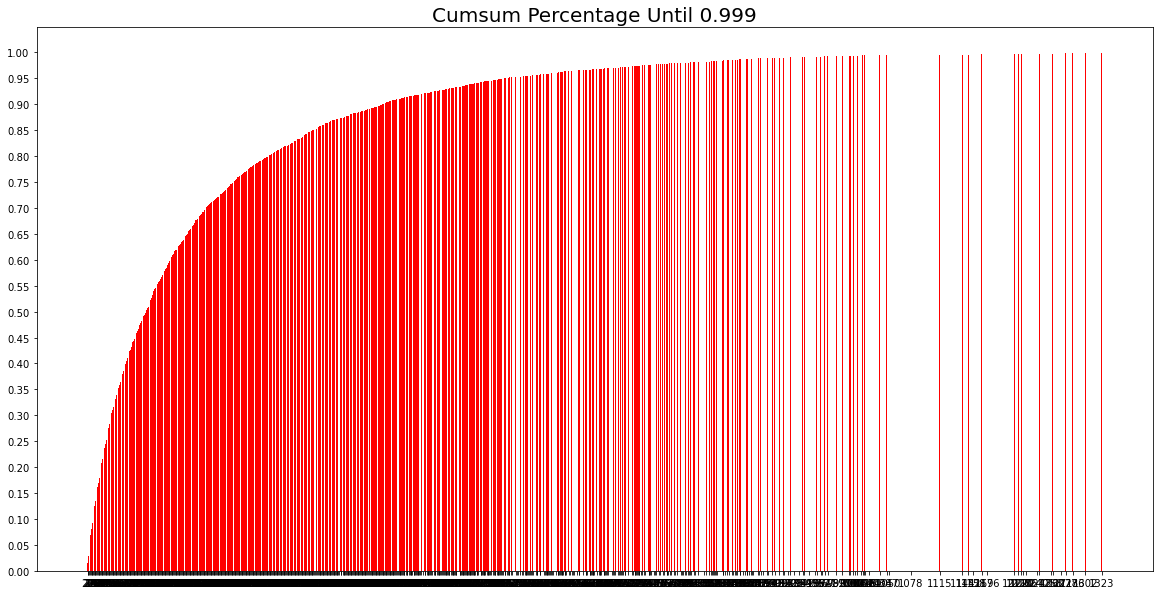

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

- 'Time' = session time
- UTC time 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [35]:
oldest, latest = data['Time'].min(), data['Time'].max()
oldest, latest

(956703932, 1046454590)

- timestamp를 time_struct 타입으로 변환합니다.

In [37]:
import time

tm_old = time.gmtime(oldest)
print(tm_old)

tm_latest = time.gmtime(latest)
print(tm_latest)

time.struct_time(tm_year=2000, tm_mon=4, tm_mday=25, tm_hour=23, tm_min=5, tm_sec=32, tm_wday=1, tm_yday=116, tm_isdst=0)
time.struct_time(tm_year=2003, tm_mon=2, tm_mday=28, tm_hour=17, tm_min=49, tm_sec=50, tm_wday=4, tm_yday=59, tm_isdst=0)


**2000년 4월 25일부터 2003년 2월 28일까지의 데이터가 있습니다.**
- session(user_id)별로 다음에 볼 영화를 예측하고자 합니다.
- 데이터 셋에 영화에 대한 평점이 있기 때문에, 1점을 준 영화데이터는 제거하겠습니다.

In [47]:
rate_low = data[data['Rating']==1]
rate_low

,UserId,ItemId,Rating,Time
180,2,3893,1,978299535
148,2,21,1,978299839
205,3,1261,1,978297663
249,4,3527,1,978294008
325,5,2717,1,978241072
...,...,...,...,...
999974,6040,2513,1,956716541
1000090,6040,2241,1,956716541
1000204,6040,1091,1,956716541
999892,6040,2402,1,956716557


- 56174개의 데이터가 있습니다. 
- 평점이 낮은 영화는 추천이 되어도 좋은 추천 시스템이 아니라고 생각하기 때문에 해당 데이터는 삭제하도록 하겠습니다.

In [217]:
data[data['Rating']>1]

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [218]:
data = data[data['Rating']>1]
len(data)

944035

## 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [52]:
# from sklearn.utils import shuffle

# shuffled_data = shuffle(data, random_state=2021)

In [209]:
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [208]:
grouping_by_user_id = data.groupby('UserId')
grouping_by_user_id.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000138,6040,858,4,956703932
999873,6040,593,5,956703954
1000153,6040,2384,4,956703954
1000007,6040,1961,4,956703977


In [219]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=2021)
print(len(train), len(test))

755228 188807


In [220]:
train.UserId.nunique() == data.UserId.nunique()

True

In [221]:
train, valid = train_test_split(train, test_size=0.2, random_state=2021)
print(len(train), len(valid), len(test))

604182 151046 188807


In [222]:
data.UserId.nunique() == train.UserId.nunique() == valid.UserId.nunique() == test.UserId.nunique()

False

In [223]:
print(data.UserId.nunique() == train.UserId.nunique())
print(data.UserId.nunique() == valid.UserId.nunique())
print(data.UserId.nunique() == test.UserId.nunique())

True
False
False


In [233]:
result = train[:-1].groupby('UserId').count().describe()

In [241]:
train[:-1].groupby('UserId').count().min()

ItemId    1
Rating    1
Time      1
dtype: int64

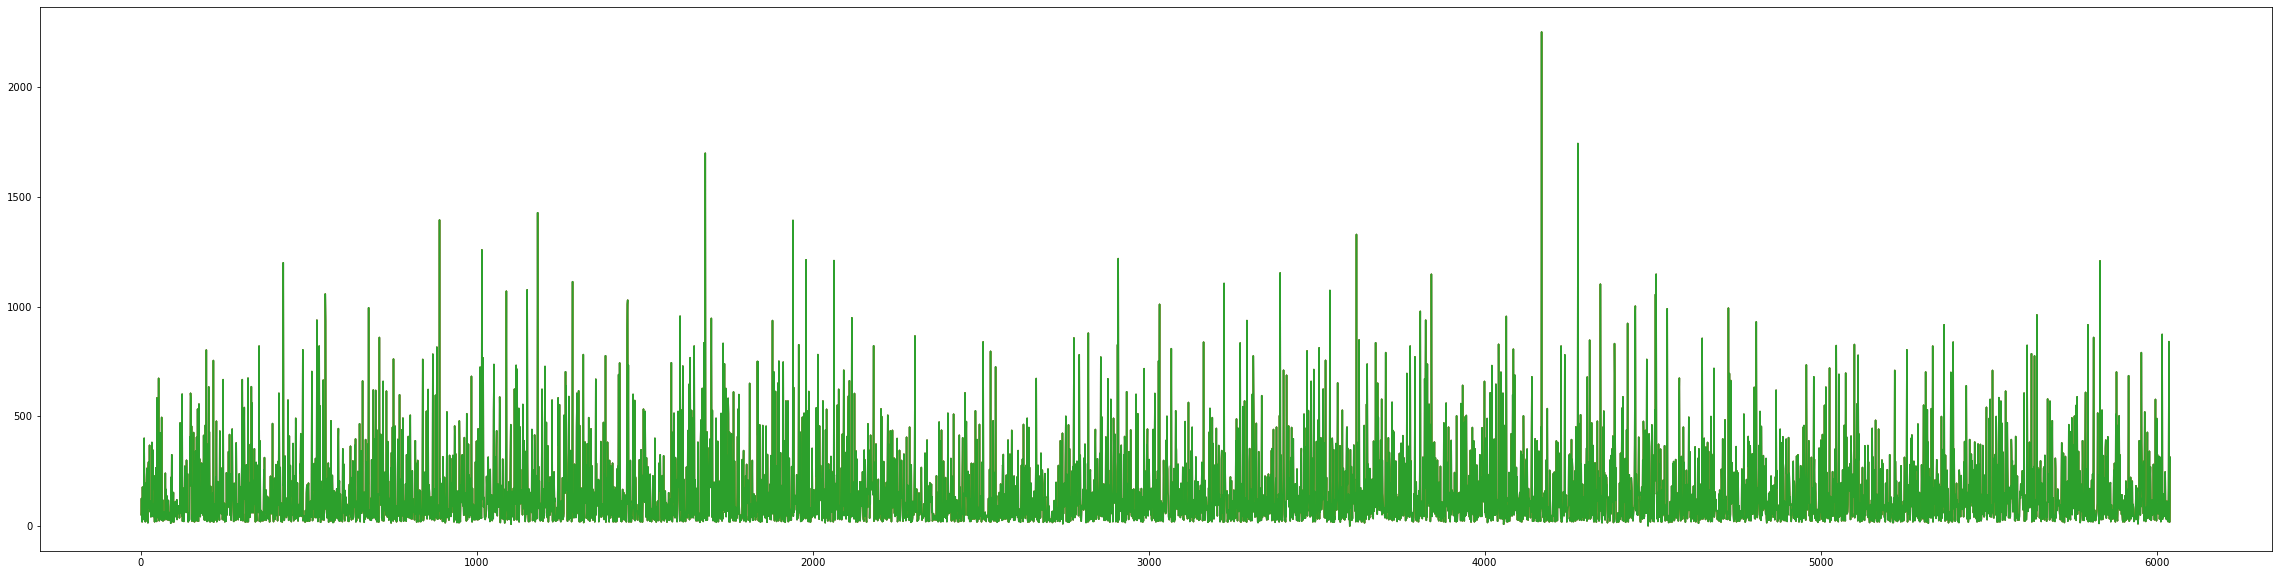

In [250]:
plt.figure(figsize=[40, 10])
plt.plot(data.groupby('UserId').count())

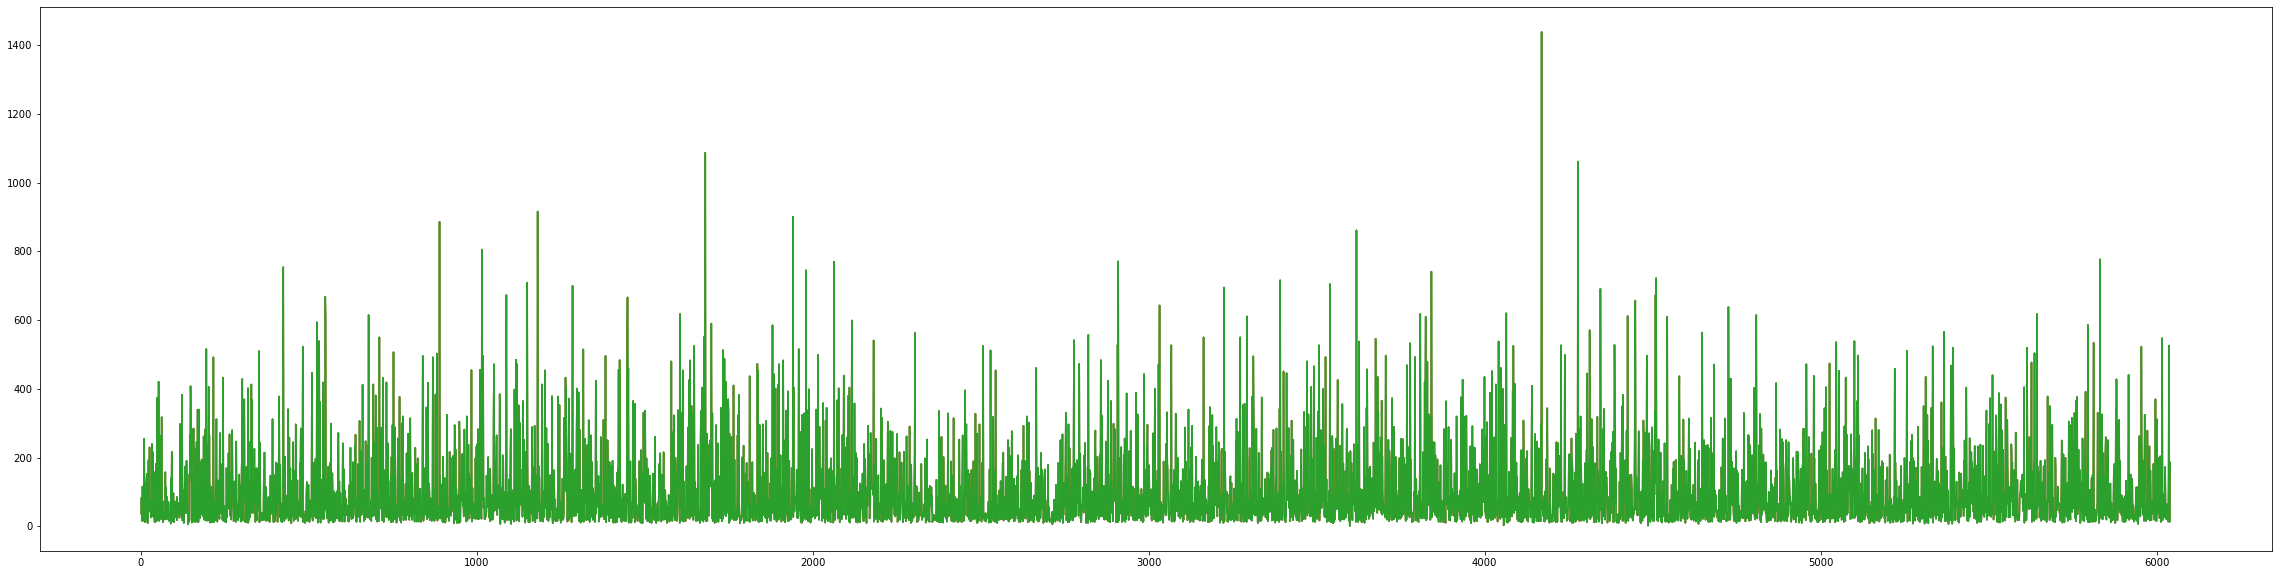

In [249]:
plt.figure(figsize=[40, 10])
plt.plot(train[:-1].groupby('UserId').count())

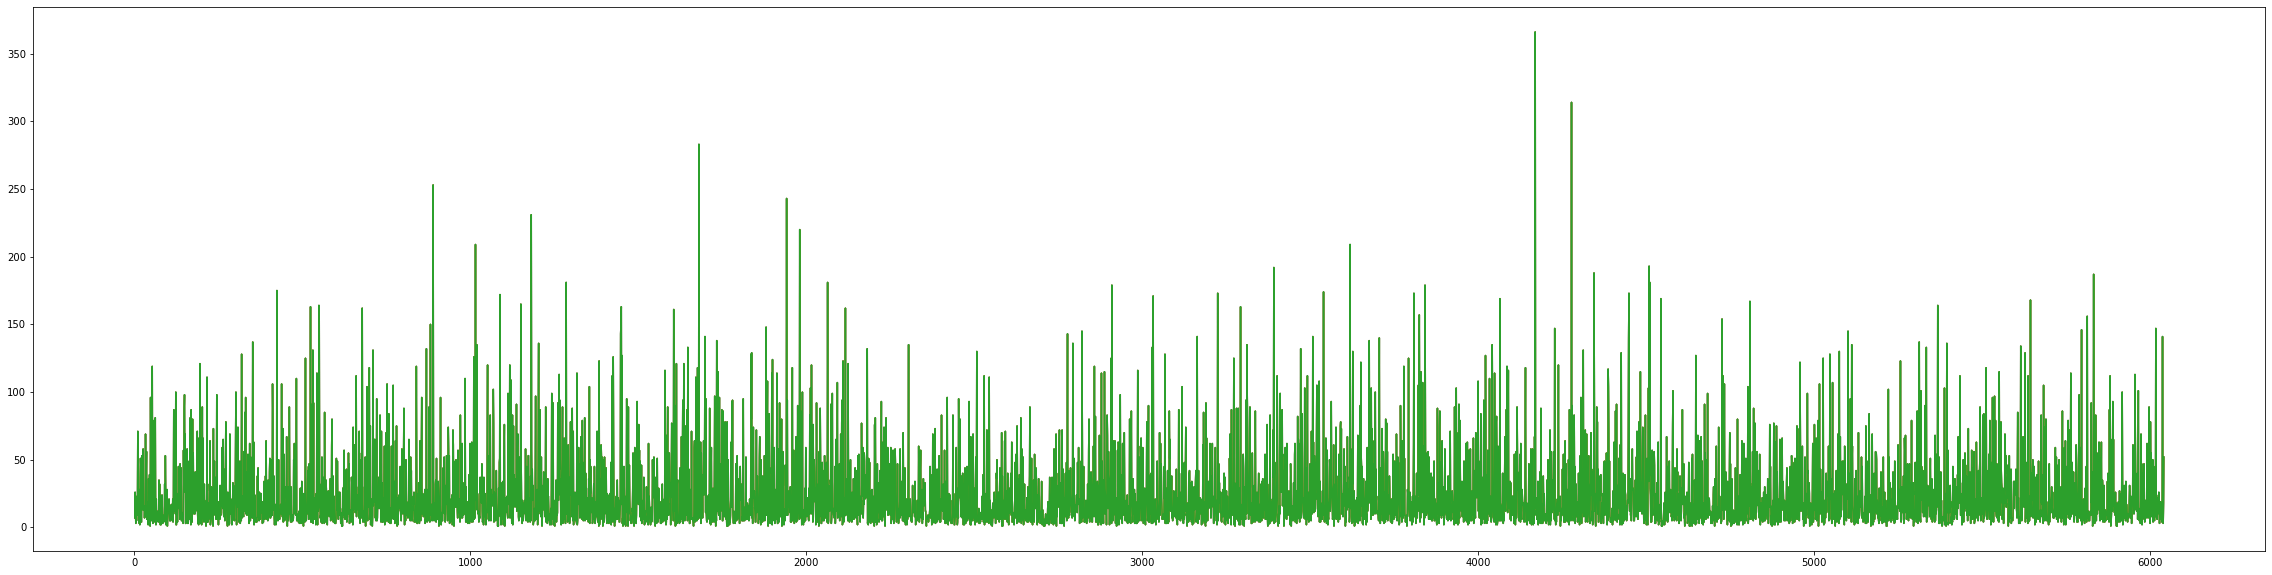

In [253]:
plt.figure(figsize=[40, 10])
plt.plot(valid[:-1].groupby('UserId').count())

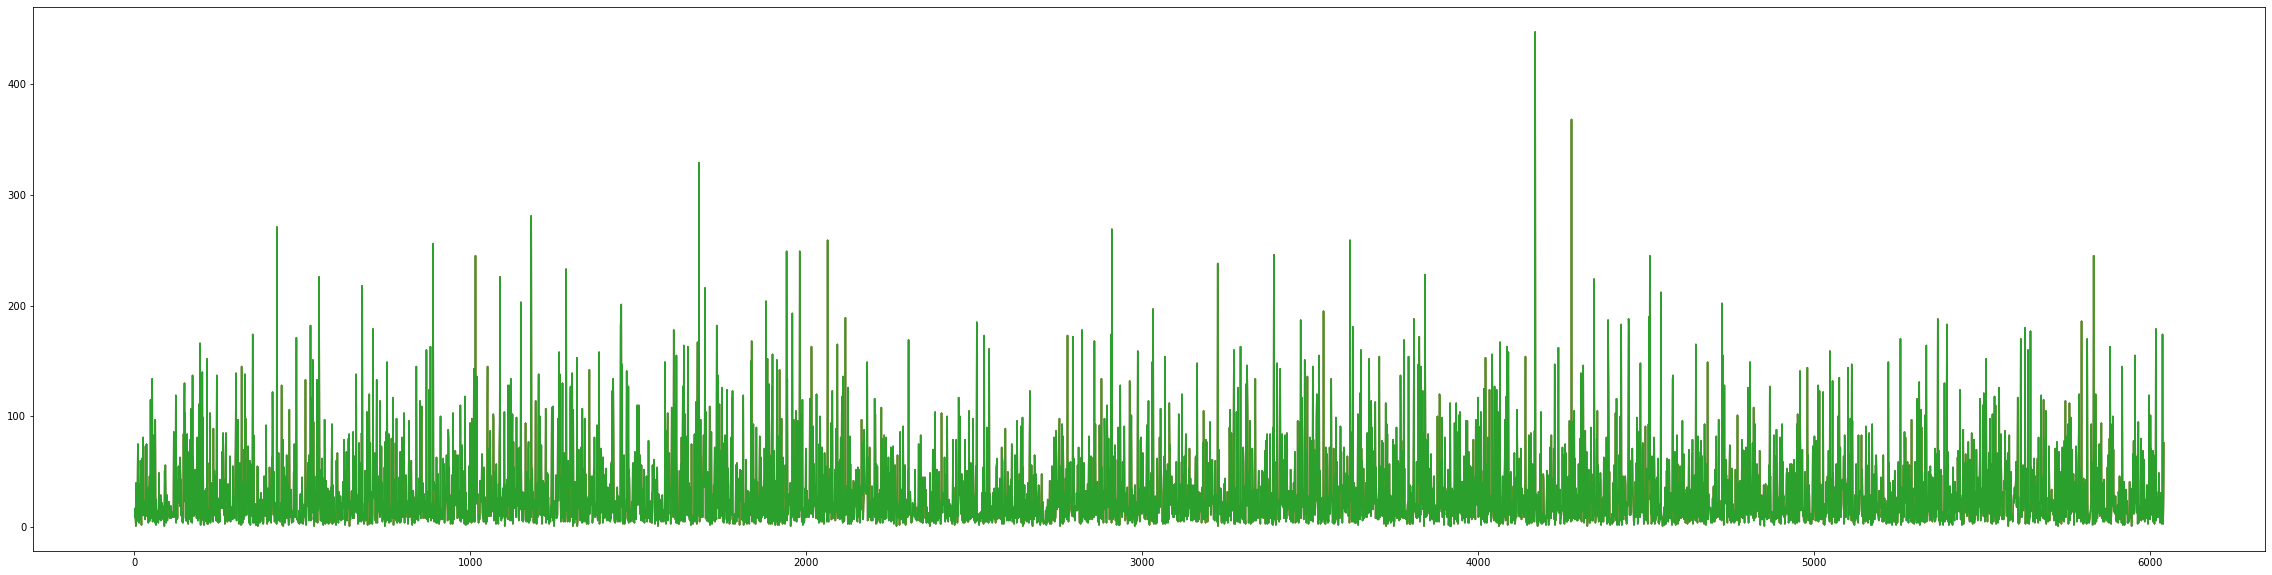

In [252]:
plt.figure(figsize=[40, 10])
plt.plot(test[:-1].groupby('UserId').count())

In [231]:
valid
[:-1].groupby('UserId').count().describe()

,ItemId,Rating,Time
count,6023.000000,6023.000000,6023.000000
mean,25.078034,25.078034,25.078034
std,29.334094,29.334094,29.334094
min,1.000000,1.000000,1.000000
25%,7.000000,7.000000,7.000000
50%,14.000000,14.000000,14.000000
75%,32.000000,32.000000,32.000000
max,366.000000,366.000000,366.000000


In [232]:
test[:-1].groupby('UserId').count().describe()

,ItemId,Rating,Time
count,6027.000000,6027.000000,6027.000000
mean,31.326697,31.326697,31.326697
std,36.323197,36.323197,36.323197
min,1.000000,1.000000,1.000000
25%,8.000000,8.000000,8.000000
50%,18.000000,18.000000,18.000000
75%,39.000000,39.000000,39.000000
max,447.000000,447.000000,447.000000


## 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

## 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

## 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

# 루브릭 평가
---
1. **Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.**   

    - 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.


2. **RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.**

    - 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
     
     
3. **세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.** 

    - 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

    
    
# 회고
---
## 어려웠던 점 
- 구현은 했지만, SRGAN 아키텍쳐에 대한 상세한 이해가 필요할 것 같습니다. 
    
## 알게된 점 
- 해상도 변환을 GAN으로 생성하는 방법에 대해 알 수 있었습니다. 

## 다짐
- 시간적인 문제로 보다 다양한 데이터에 대한 실험을 하지 못한 것이 아쉬웠던 프로젝트입니다. 보통 제공되는 데이터는 어느정도의 결과를 얻을 수 있는 좋은 데이터이기 때문에, 실제 다양한 데이터로 실험을 해야 강건성에 대한 평가를 할 수 있습니다. 사전학습된 모델을 사용하면 정말 빠른 시간내에 결과를 얻을 수 있다는 것을 알았고, 다량의 데이터와 컴퓨팅 파워의 중요성을 느꼈습니다. 또한 결과를 단지 사람 눈으로만 평가해야한다는 것이 아쉽기도 했습니다. 실제로 gif의 경우엔 제 눈에는 bicubic으로 고화질 변환한 이미지가 원본 저화질 이미지보다 화질이 떨어지게 느껴졌는데, 객관적인 지표가 없어 정확한 평가가 어려웠습니다.